# Preprocessing

***
## Notes

 - GSw: use max_extent or another metric?
 - Remove points overlying permanent water from classifier? Or remove later?
 - Height Above Nearest Drainage ([HAND](https://www.mdpi.com/2072-4292/8/5/386)) data useful for separating areas where water is more or less likely to occur 

In [1]:
%matplotlib inline
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import ee; ee.Initialize()

# Configure the pretty printing output
pp = pprint.PrettyPrinter(depth=4)

## Image acquisition

In [2]:
# Landsat 8 scene from Iowa City, IA (2016)
# scene = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')
scene = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170105')

## Pansharpen and visualize the scene in true color

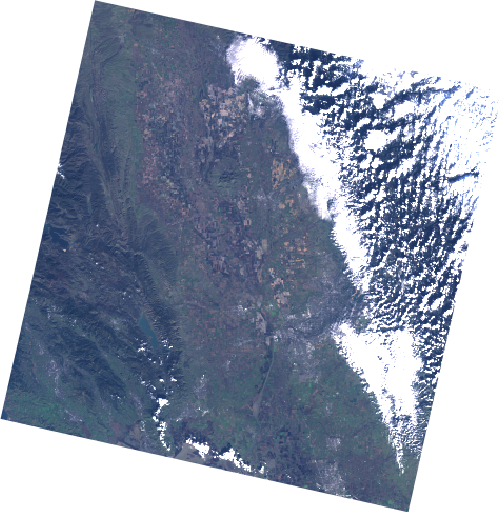

In [3]:
# Visualize part of image in RGB
# poly = ee.Geometry.Polygon(
#     [[[-91.78812019737575, 41.95033307316587],
#            [-91.79361336143825, 41.90333364712244],
#            [-91.71739571007106, 41.9012894084067],
#            [-91.72151558311793, 41.95288639774597]]])

# parameters for stretching
# visparams = {'bands': 'B4,B3,B2', 
#              'min': 0,
#              'max': 0.25,
#              'region':poly.getInfo()['coordinates']}

visparams = {'bands': 'B4,B3,B2', 
             'min': 0,
             'max': 0.25}

# url = scene.getThumbUrl(visparams) 
# IPython.display.Image(url=url, format='png', embed=True)

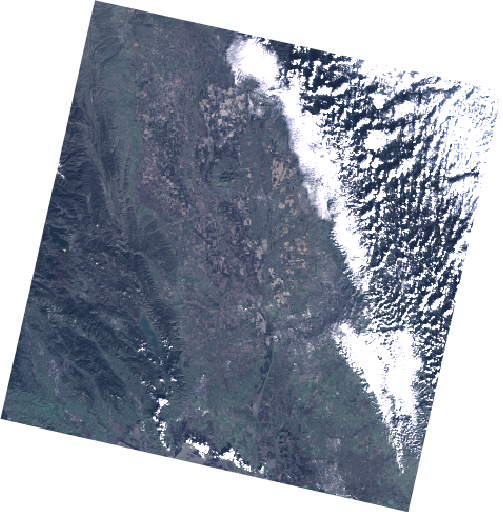

In [4]:
# Pansharpen the image to get a better resolution
def panSharpenL8(scene):
    hsv = scene.select('B4', 'B3', 'B2').rgbToHsv()
    sharpened = ee.Image.cat([hsv.select('hue'), 
                              hsv.select('saturation'), 
                              scene.select('B8')]).hsvToRgb()
    return sharpened

# parameters for stretching
# visparams = {'min':0,
#              'max': 0.25,
#              'gamma': [1.3, 1.3, 1.3],
#              'region':poly.getInfo()['coordinates']}

visparams = {'min':0,
             'max': 0.25,
             'gamma': [1.3, 1.3, 1.3]}

sharpened = panSharpenL8(scene)

# # Get thumbnail URL from GEE server
# url = sharpened.getThumbUrl(visparams) 
# IPython.display.Image(url=url, format='png', embed=True)

## Dataset Inventory:

  - SRTM 30m DEM
      - aspect
      - slope
      - curvature
      - SPI (stream power index)
      - TWI (topographic wetness index)
      - HAND (height above nearest drainage)
      - Climatological data? (precip)
  - Land cover 
  - Distance from permanent water extent
  - Lithography

## Detect inundation

From [Feyisa et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0034425713002873). Using a threshold of 0, and only incorporating AWEInsh, not the AWEIsh used for cloud shadows. Might be necessary later.

In [ ]:
# AWEI Function from Feyisa et al. (2014) to detect water
def feyisa(image):
    return image.expression("4 * (b('B3')-b('B6')) - (0.25 * b('B5') + 2.75 * b('B7'))").gt(0)

In [ ]:
#------------------- Mask out clouds, cloud shadows, and snow/ice

# Compute the bits we need to extract
def getQABits(image, start, end, newName):
    pattern = 0
    i = start
    for i in range(start, end+1):
        pattern += 2**i
    # Return a single band image of the extracted QA bits, giving the band a new name
    return image.select([0], [newName])\
              .bitwiseAnd(pattern)\
              .rightShift(start);

# Cloud shadows QA (Landsat 8, T1 TOA)
def cloud_shadowsQA(image):
    QA = image.select(['BQA'])
    return getQABits(QA, 7, 8, 'cloud_shadows').eq(1)

# Clouds QA (Landsat 8, T1 TOA)
def cloudsQA(image):
    QA = image.select(['BQA'])
    return getQABits(QA, 4, 4, 'clouds').eq(0)

def snowQA(image):
    QA = image.select(['BQA'])
    return getQABits(QA, 9, 10, 'snow_ice').eq(1)

cs = cloud_shadowsQA(scene)
c = cloudsQA(scene)
s = snowQA(scene)

sceneFlood = feyisa(scene).rename('floodBinary') # Detect water
sceneFlood = sceneFlood.updateMask(cs).updateMask(c).updateMask(s) # Mask out clouds, cloud shadows, and snow/ice
# sceneFlood = sceneFlood.updateMask(sceneFlood.eq(1)) # Mask out non-water for visualizing

## Fetch auxiliary datasets

In [6]:
# Permanent Water Extent, Joint Research Centre, Global Surface Water dataset (JRC GSW)
GSW = ee.Image('JRC/GSW1_0/GlobalSurfaceWater') # Permanent Water Extent, Joint Research Centre, Global Surface Water dataset (JRC GSW)
GSW_trans = GSW.select(5) # Band 5 ("transition") has a permanent water code, 1
GSW_perm = GSW_trans.lt(2).gt(0) # Get only permanent water extent, code 1

nlcd = ee.Image('USGS/NLCD/NLCD2011') # NLCD: National Land Cover Dataset

# JRC permanent water extent
waterJRC = ee.Image.constant(0).blend(ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('occurrence').gte(50)).select(['constant'],['water'])
# .clip(region)


### HydroSHEDS lvl 6 for North America 

In [7]:
# Is this necessary? Should compare values of TWI/SPI/other topo features calculated in watersheds vs. calculated in just image extent

# Find drainage areas that intersect image extent
watershed = ee.FeatureCollection("ft:166OsLQQh86M6GLvQeNgER7IxX8ZzgZngFMbFLRZJ")

def find_watersheds(ft, scene):
    ft_bounds = ft.geometry()
    scene_bounds = scene.geometry()
    return ft.filterBounds(scene_bounds)

watershed = find_watersheds(watershed, scene)
region = watershed

## Calculate flood conditioning factors

Slope, curve, aspect, impervious surface, distance from water features, TWI, SPI, HAND (height above nearest drainage), water mask. Climatological factors also available but not sure how to integrate. 

* Might not even need to clip to watersheds - might just be able to clip to image and be good.

* One problem might be that the CNN just learns the DEM, since most of the aux variables come from a DEM. Would spectral data be useful? Might be useful to put longitude and latitude in to account for spatial autocorrelation.

* Are these features all the same resolution, and have the same grid overlap? Should be fine if we do points to train, but if there is some spatial mismatch then might need to do some averaging.

### Topographical features

In [8]:
# If images are in the US, use 'USGS/NED' 10m DEM, other use 'USGS/SRTMGL1_003'
DEM = ee.Image("USGS/NED") # 10-m DEM from USGS National Elevation Dataset

slope = ee.Terrain.slope(DEM)
curve = DEM.convolve(ee.Kernel.laplacian8()).resample().select(['DEM'],['curve'])
aspect = ee.Terrain.aspect(DEM)

flowAcc = ee.Image('WWF/HydroSHEDS/15ACC')

nhd = flowAcc.clip(region).gte(2000) # why 2000?
water = ee.Image('ESA/GLOBCOVER_L4_200901_200912_V2_3').select(0).eq(210).clip(region)
kern = ee.Kernel.euclidean(2000, 'meters') # What does this do?
distance = water.distance(kern)
rdist = nhd.distance(kern).clip(region).select(['b1'],['distanceRiver'])

# Calculating TWI and SPI
# I don't think we need to map these functions over each watershed because flowAcc is already
# calculated by HydroSHEDS. However, there are different ways to calculate flowAcc (http://gis4geomorphology.com/topographic-index-model/)
# so it might be worthwhile to calculate the values in alternative ways if they are not predicting well

# Topographic wetness index is LN([flowaccum+1*cellarea]/tanslope)
    # It is defined as ln(a/tanβ) where a is the local upslope area draining 
    # through a certain point per unit contour length and tanβ is the local slope.

# Stream power index is LN([flowaccum+1*cellarea]*tanslope)
    # It is defined as ______
    # Note that both TWI and SPI assume steady state
    
floodFlowAcc = flowAcc.clip(region)
imageValue1 = ee.Image.constant(1)
floodFlowAccPlusOne = floodFlowAcc.add(imageValue1) # so no 0s when taking the log
pixelArea = ee.Image.pixelArea().mask(floodFlowAcc.mask())
catchmentArea = floodFlowAccPlusOne.multiply(pixelArea) # CA= (flow accum + 1 * cell^2)
nonZeroSlopes = slope.add(ee.Image.constant(0.0000001)) # so low slopes don't get left out
slopeRadians = nonZeroSlopes.multiply(3.141592653/280)
tanSlope = slopeRadians.tan()

topoIndex = catchmentArea.divide(tanSlope)
twi = topoIndex.log().select(['b1'], ['twi']) # what does this do exactly, why are we selecting b1?

streamPower = catchmentArea.multiply(tanSlope)
spi = streamPower.clip(region).select(['b1'], ['spi'])

# Height above nearest drainage
hand = ee.ImageCollection('users/gena/global-hand/hand-100').mosaic().select(['b1'],['hand']).clip(region)

### Other features

 * Wanted to include lat/lon to take autocorrelation into account (cloudy areas adjacent to flooded areas likely to also be flooded). But this doesn't seem necessary because all of the features are themselves autocorrelated

In [9]:
# Distance from permanent water extent
dist = GSW_perm.fastDistanceTransform() # distance from permanent water bodies

# Hansen global forest coverage
hansen = ee.Image("UMD/hansen/global_forest_change_2015").select('datamask').clip(region)
hansenWater =  hansen.select([0]).remap([0,1,2], [1,0,1])
hansenLand = hansen.select([0]).remap([0,1,2], [0,1,0])

# Land Cover
# If only including US floods, use 2011 NLCD 
nlcd = ee.Image('USGS/NLCD/NLCD2011') # NLCD: National Land Cover Dataset
# Otherwise use this 2009 ESA global dataset
# imp = ee.Image('ESA/GLOBCOVER_L4_200901_200912_V2_3').select(0).eq(190).select(['landcover'],['impervious']).clip(region);

# Make these binary features instead of categorical. Not sure if neural nets prefer one type of data over another
# This SO answer says decision trees don't like binary data (https://datascience.stackexchange.com/questions/20132/is-it-better-to-have-binary-features-rather-than-class-ones/20137)
imp = nlcd.select(2) # impervious surfaces
# Add more ... probably need to aggregate a bunch of NLCD classes, but not sure how to do that

# US Lithography
lith = ee.Image("CSP/ERGo/1_0/US/lithology")

## Cloudmask

Rather than generating artificial clouds using, say, Perlin or simplex noise, we can just use the cloud masks that come with Landsat images (any Landsat image, but obviously not an image that is part of our dataset). Using cloud cover of 20-30% right now. Not sure if there is any downside to doing this versus Perlin/Simplex noise, but couldn't figure out a way to generate cloud cover server side in GEE.

Another important point is that the cloud cover is really more for aesthetic purposes, at least until we use the classifer to predict all cloud-covered pixels. To speed things up, we could just take a random subset of the sampled points as our "cloud pixels" for testing. But then again, we ultimately want to have a figure of red/green, incorrect/correct predictions over cloud areas, which we would need artificial clouds for.

All of these methods for generating artificial cloud cover assume that cloud presence is equally probable in all pixels of an image, which isn't necessarily true if we are dealing with mountains /cloud shadow areas, large water bodies, etc. Doesn't seem too important at this point though. 

In [10]:
# Getting images with 20-30% cloudcover and taking their cloudmask to use as cloud cover for classifier
extent = scene.geometry()
ic = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(extent)

# Do we need a geometry? Or can we just filter only by cloudscore? What exactly is this used for?
def getCloudScore(scene):
    cloud = ee.Algorithms.Landsat.simpleCloudScore(scene).select('cloud')
    cloudiness = cloud.reduceRegion(ee.Reducer.mean(), extent, 30)
    return scene.set(cloudiness)

# Find images with 20-30% average cloud cover per pixel
# from: https://gis.stackexchange.com/questions/252685/filter-landsat-images-base-on-cloud-cover-over-a-region-of-interest/252785
withCloudiness = ic.map(getCloudScore)
filteredCollection = withCloudiness.filter(ee.Filter.gt('cloud', 20))
filteredCollection = filteredCollection.filter(ee.Filter.lt('cloud', 30))

# Arbitrarily sort by date acquired and take the first image that matches cloudiness criteria
sortedCollection = filteredCollection.sort('DATE_ACQUIRED')
cloudMask = ee.Image(sortedCollection.first())

# Select the QA band and pixels that are cloudy (bit value = 32)
cloudMask = cloudMask.select('pixel_qa').bitwiseAnd(32).neq(0)

## Add all features to one image

In [11]:
# Combine all features into one image
features = DEM.addBands([twi, spi, flowAcc, nhd, water, rdist, slope, curve, aspect, hand, lith, imp, cloudMask, water]) 

# Rescale features. Skipping this for now - CNNs might be scale invariant, but need to read up more on that.
# features = features.map(ee.Image.unitScale())

# Clip features to image region
features = features.clip(extent)

## Export to Drive

In [12]:
# mytask = ee.batch.Export.scene.toDrive(features, folder='data_earth_engine', description='myExportTableTask')
# ee.batch.data.startProcessing(mytask.id, mytask.config)

## Extract values of randomly sampled points to a table

In [13]:
# Number of points to sample
sample_n = 10000

# Should we stratify this? To get a certain % from clouds and certain % from non-clouds?
scene = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')

pts = ee.FeatureCollection.randomPoints(extent, sample_n) # randomly sampled points
 
sample = features.reduceRegions(pts, ee.Reducer.first()) # extract values of image stack to points

## Export table

In [14]:
exportFolder = 'GEE_exports'
tableName = 'LC08_044033_20170105_sample_pts'
task=ee.batch.Export.table.toDrive(collection=sample,
                                   folder = exportFolder,
                                   description = tableName, 
                                   fileFormat='CSV')
task.start()
task.status()

{'id': 'BPBY6IXAUCY67ZHAOSCCMKBJ',
 'state': 'READY',
 'creation_timestamp_ms': 1548459139683,
 'update_timestamp_ms': 1548459139683,
 'description': 'LC08_044033_20170105_sample_pts',
 'task_type': 'EXPORT_FEATURES'}